In [1]:
import os
import glob
import sys
import astropy.io.fits
import matplotlib
import numpy as np
import time

import skimage.transform
import cv2
import psycopg2
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import pandas.io.sql as psql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm

from eCallistoProject import plot_config

module_path = os.path.abspath(os.path.join('radiospectra'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import radiospectra

from radiospectra.sources import CallistoSpectrogram

from matplotlib.backends.backend_pdf import PdfPages

import warnings
warnings.filterwarnings("ignore")


In [10]:
def connect_database(dbName):
    """
    The function to create database

    Returns:
        cur  : Use the connection to get a cursor that will be used to execute queries.
        conn : The connection towards current connecting database.
    """

    # Connect to an existing database
    conn = psycopg2.connect("host=localhost port=5432 dbname={} user=postgres password=ecallistohackorange".format(dbName))

   # Set one or more parameters for the next transactions or statements in the current session.
    conn.set_session(autocommit=True)

   # Open a cursor to perform database operations
    cur = conn.cursor()

    return cur, conn


In [11]:
cur, conn = connect_database('validation')

In [8]:
def get_data_frame1():
    dataframe = psql.read_sql("SELECT * from ecallisto WHERE start_time BETWEEN '2020-10-07 12:00:00'  AND '2020-10-07  15:00:00'",conn)
    return dataframe

get_data_frame()

id                               file_name instrument_name  \
0    2996        HUMAIN_20201007_120000_59.fit.gz          HUMAIN   
1    2997          MRT1_20201007_120500_02.fit.gz            MRT1   
2    2998          MRT2_20201007_120000_01.fit.gz            MRT2   
3    2999          MRT3_20201007_120000_02.fit.gz            MRT3   
4    3000        TRIEST_20201007_120000_57.fit.gz          TRIEST   
..    ...                                     ...             ...   
544  4446  SPAIN-ALCALA_20201007_144503_01.fit.gz    SPAIN-ALCALA   
545  4500          KRIM_20201007_120310_00.fit.gz            KRIM   
546  4501          KRIM_20201007_121810_00.fit.gz            KRIM   
547  4502          KRIM_20201007_123310_00.fit.gz            KRIM   
548  4503          KRIM_20201007_124810_02.fit.gz            KRIM   

              start_time             end_time       std  
0    2020-10-07 12:00:00  2020-10-07 12:15:00  1.501412  
1    2020-10-07 12:05:00  2020-10-07 12:20:00  0.810399  
2    2020-10-07 12:00:00  2020-10-07 12:15:00  1.349114  
3    2020-10-07 12:00:00  2020-10-07 12:15:00  0.633443  
4    2020-10-07 12:00:00  2020-10-07 12:15:00  2.180424  
..                   ...                  ...       ...  
544  2020-10-07 14:45:03  2020-10-07 15:00:03  1.409199  
545  2020-10-07 12:03:10  2020-10-07 12:18:10  0.826016  
546  2020-10-07 12:18:10  2020-10-07 12:33:10  0.717771  
547  2020-10-07 12:33:10  2020-10-07 12:48:10  0.835465  
548  2020-10-07 12:48:10  2020-10-07 13:00:07  0.901728  

[549 rows x 6 columns]

In [16]:
def get_data_2017():
    dataframe_2 = psql.read_sql("SELECT * from ecallisto_2017",conn)
    return dataframe_2

get_data_2017()

id                                  file_name  instrument_name  \
0        1  AUSTRIA-UNIGRAZ_20170906_040000_02.fit.gz  AUSTRIA-UNIGRAZ   
1        2       ACCIMT-SRI_20170906_001500_59.fit.gz       ACCIMT-SRI   
2        3       ACCIMT-SRI_20170906_003003_59.fit.gz       ACCIMT-SRI   
3        4       ACCIMT-SRI_20170906_004508_59.fit.gz       ACCIMT-SRI   
4        5       ACCIMT-SRI_20170906_010013_59.fit.gz       ACCIMT-SRI   
...    ...                                        ...              ...   
2608  2609             ZSTS_20170906_173000_59.fit.gz             ZSTS   
2609  2610             ZSTS_20170906_174500_59.fit.gz             ZSTS   
2610  2611             ZSTS_20170906_180000_59.fit.gz             ZSTS   
2611  2612             ZSTS_20170906_181500_59.fit.gz             ZSTS   
2612  2613             ZSTS_20170906_183000_59.fit.gz             ZSTS   

              start_time            end_time  
0    2017-09-06 04:00:00 2017-09-06 04:15:00  
1    2017-09-06 00:15:00 2017-09-06 00:30:00  
2    2017-09-06 00:30:00 2017-09-06 00:45:00  
3    2017-09-06 00:45:00 2017-09-06 01:00:00  
4    2017-09-06 01:00:00 2017-09-06 01:15:00  
...                  ...                 ...  
2608 2017-09-06 17:30:00 2017-09-06 17:45:00  
2609 2017-09-06 17:45:00 2017-09-06 18:00:00  
2610 2017-09-06 18:00:00 2017-09-06 18:15:00  
2611 2017-09-06 18:15:00 2017-09-06 18:30:00  
2612 2017-09-06 18:30:00 2017-09-06 18:44:00  

[2613 rows x 5 columns]

In [15]:
def get_std():
    Std_dataframe = psql.read_sql("SELECT instrument_name, AVG(DISTINCT std) FROM ecallisto GROUP BY instrument_name ORDER BY AVG(std)", conn)

    return Std_dataframe

get_std()

instrument_name       avg
0   NORWAY-NY-AALESUND  0.311296
1         SWISS-BLEN7M  0.618839
2                 MRT3  0.663641
3                 OOTY  0.666699
4     NORWAY-RANDABERG  0.709590
5                 MRT1  0.802606
6         ALASKA-COHOE  0.824646
7                 KRIM  0.813738
8         INDIA-IISERP  0.872621
9         SWISS-BLEN5M  0.879435
10     SPAIN-PERALEJOS  0.973684
11              MEXART  0.940773
12         SWISS-IRSOL  0.961846
13                KASI  0.974714
14           INDONESIA  1.107681
15  AUSTRIA-MICHELBACH  1.151692
16      Australia-LMRO  1.166658
17  Germany-Hildesheim  1.196235
18             GLASGOW  1.233716
19                MRT2  1.302225
20       INDIA-UDAIPUR  1.259727
21      NEWZEALAND-AUT  1.398733
22           GREENLAND  1.512683
23        SPAIN-ALCALA  1.448214
24              TRIEST  1.537344
25              ALMATY  1.636759
26    AUSTRIA-Krumbach  1.714541
27     AUSTRIA-UNIGRAZ  1.772087
28             URUGUAY  1.790214
29        SWISS-HB9SCT  1.812853
30      AUSTRIA-OE3FLB  1.970255
31          ROSWELL-NM  1.966106
32                SSRT  1.990792
33       JAPAN-IBARAKI  2.296074
34         INDIA-GAURI  2.140668
35    SWISS-HEITERSWIL  2.251046
36       ALGERIA-CRAAG  2.238290
37        ALASKA-HAARP  2.223515
38                 MRO  2.369234
39         SWISS-MUHEN  2.422290
40      Australia-ASSA  2.408867
41    ALASKA-ANCHORAGE  2.356057
42  SWISS-Landschlacht  2.614901
43    USA-ARIZONA-ERAU  2.614375
44              HUMAIN  2.475792
45      SPAIN-SIGUENZA  3.213653

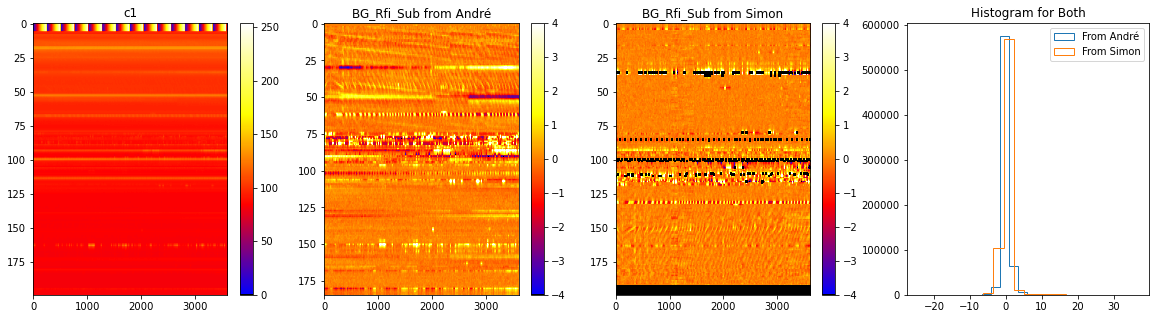

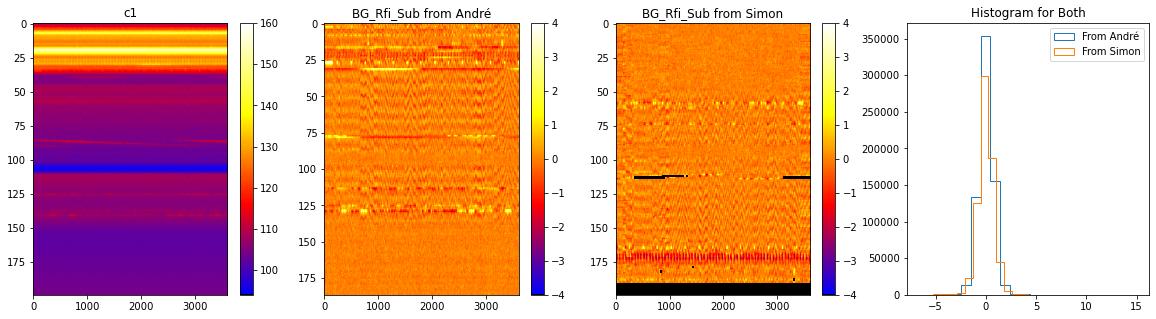

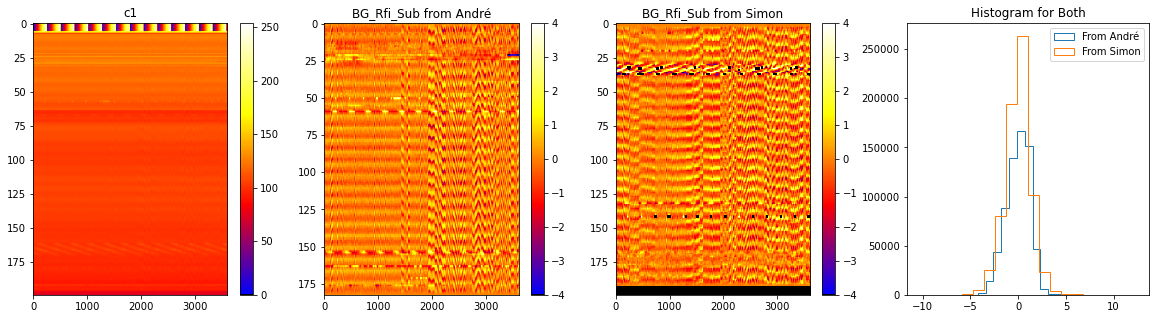

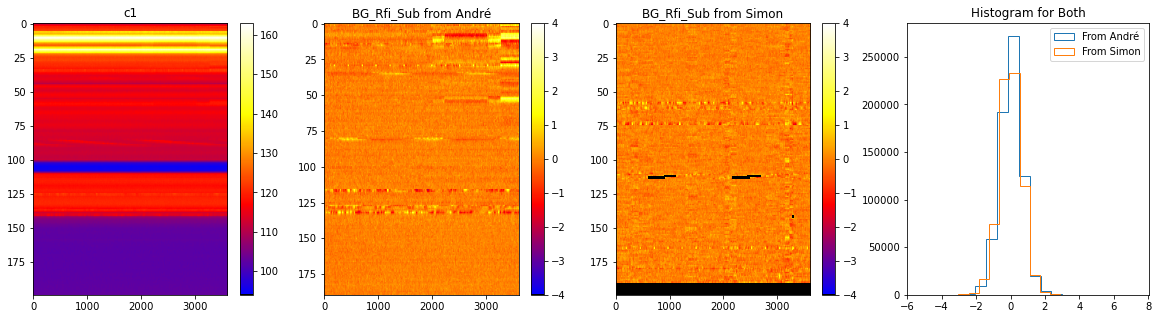

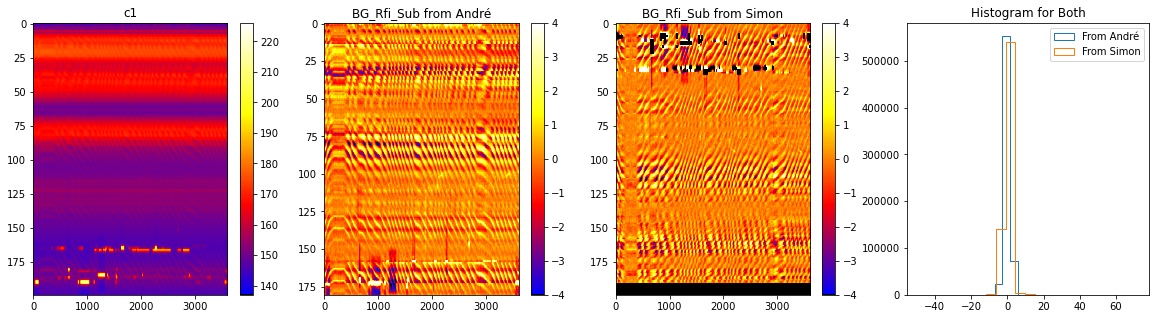

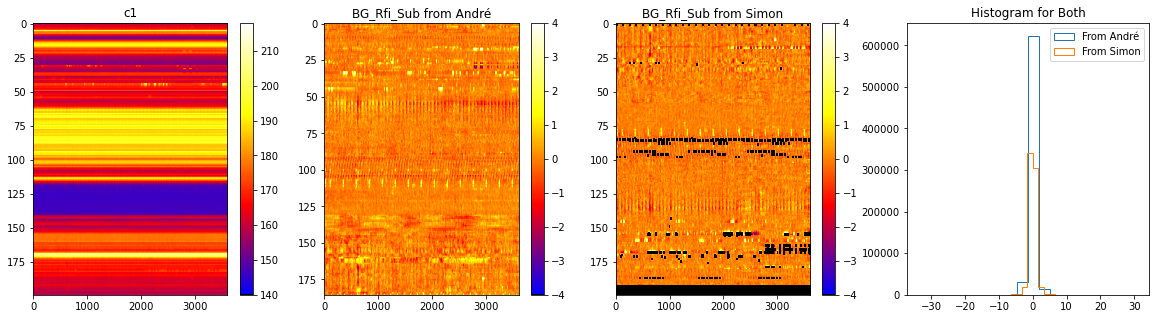

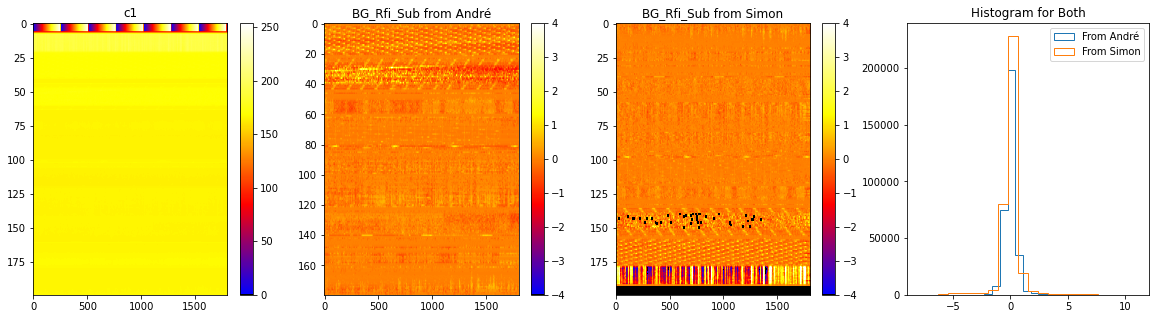

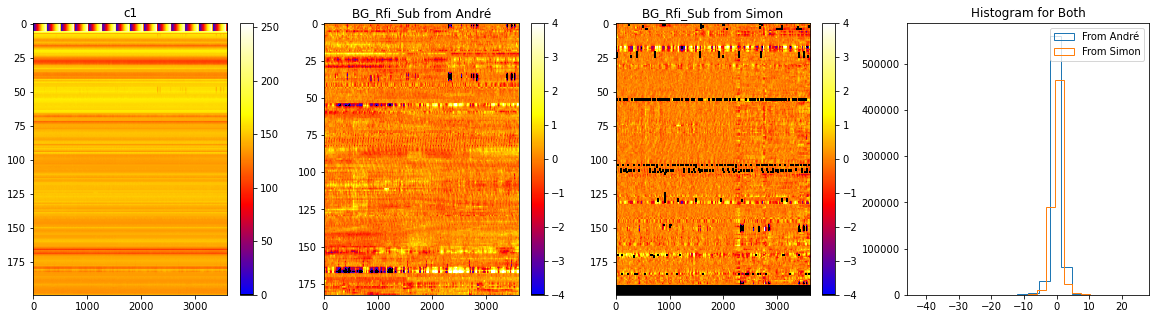

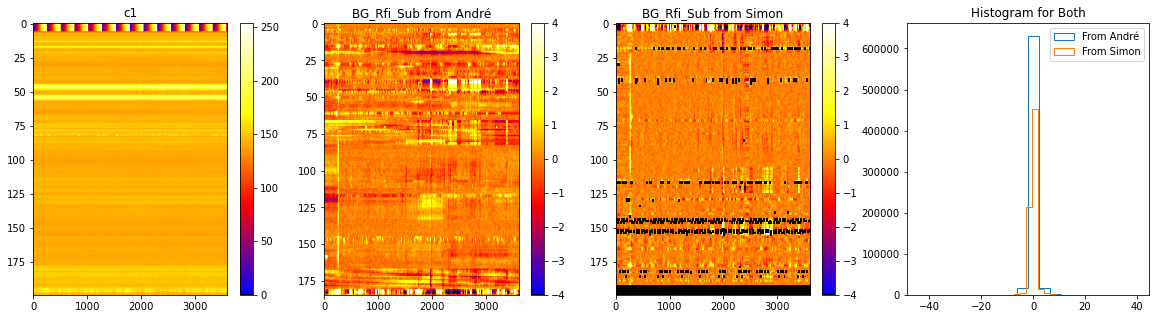

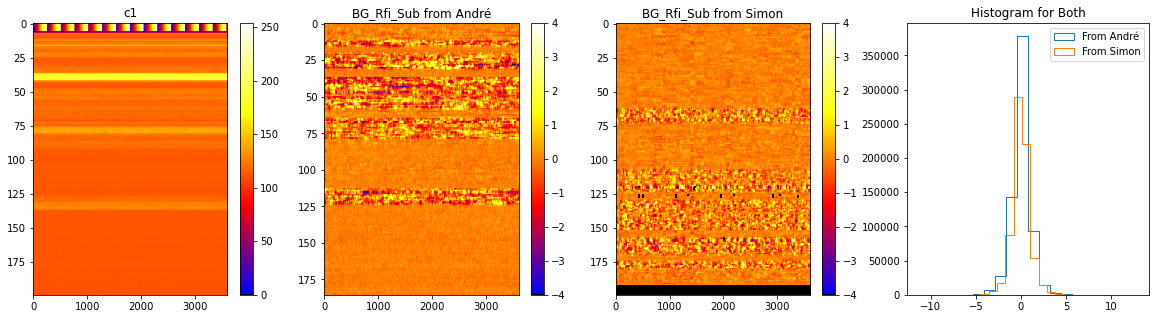

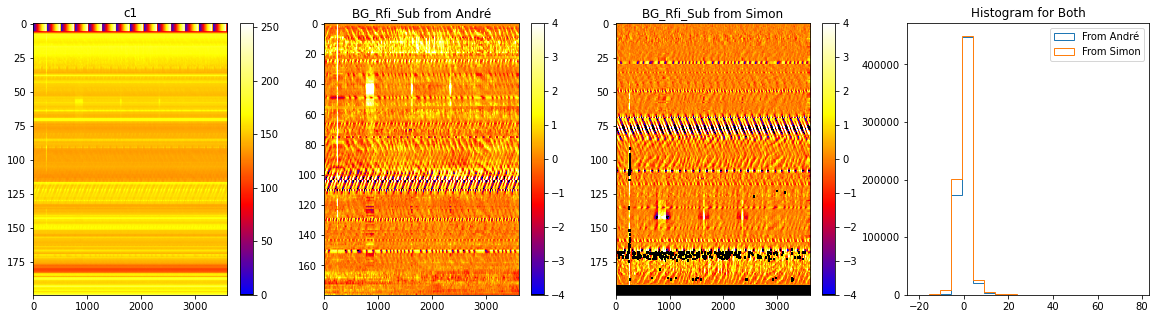

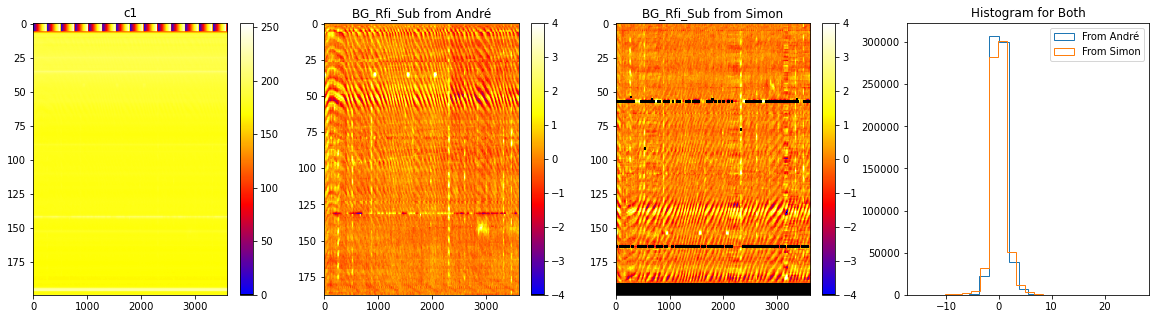

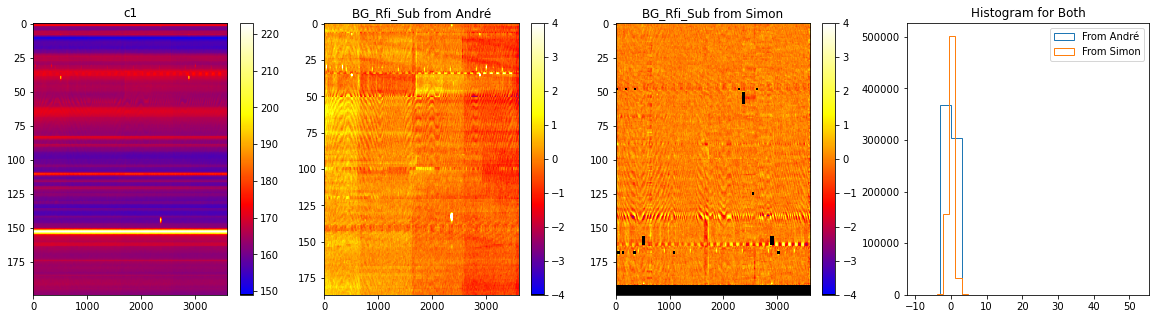

KeyboardInterrupt: 

In [105]:
ecallisto_DB = get_data_frame()

path = 'R:\\radio\\2002-20yy_Callisto\\2020\\10\\07'

for file in ecallisto_DB["c2"]:

    full_path = os.path.join(path,file)
    data = get_fits_data(full_path)

    # # From Andrè

    # data_bs_A = constbacksub(data)
    # data_elim_A = elimwrongchannels(data_bs_A)                        
    # data_hist_A = data_elim_A.flatten

   
    spec = CallistoSpectrogram.read(full_path)

    # From Kushtrim
    spec2 = spec.subtract_bg("constbacksub", "elimwrongchannels")

    # From Simon 
    bgs,_,_,_= spec.subtract_bg_sliding_window(window_width=200, affected_width=1, amount=0.05, change_points =True)

    array_std = bgs.data.std()
    rfi_rm = bgs.remove_single_freq_rfi(threshold = 8 * array_std, row_window_height=3)
    rfi_sub = np.nan_to_num(rfi_rm, nan=0.0)
    data_S = rfi_sub.data    
    data_hist_S = data_S.flatten


    
    # Defining the Colormap 
    my_colormap = matplotlib.colors.LinearSegmentedColormap.from_list("myColorMap",plot_config.COLORMAP/255)

    # Plotten
    fig = plt.figure()
    fig.set_size_inches(20, 5)
    
    
    # First Column 
    plt.subplot(1, 4, 1)                
    plt.title(file)
    data_1 = plt.imshow(data, aspect='auto', cmap=my_colormap)                   
    plt.colorbar(data_1)


    # Second Column
    plt.subplot(1, 4 , 2)
    plt.title('BG_Rfi_Sub from André')
    data_2 = plt.imshow(spec2, aspect='auto', cmap=my_colormap, vmin=-4, vmax=4 )  
    plt.colorbar(data_2)


    # Third Column
    plt.subplot(1, 4 , 3)  
    plt.title('BG_Rfi_Sub from Simon')
    my_colormap.set_bad(color='black')# set the black color for the NAN Values
    data_3 = plt.imshow(data_S, aspect='auto', cmap=my_colormap, vmin=-4, vmax=4)                   
    plt.colorbar(data_3)
    


    # Forth Column
    plt.subplot(1, 4 , 4)
    plt.title('Histogram for Both')        
    plt.hist(data_hist_A(),histtype='step', bins= 20, label='From André')
    plt.hist(data_hist_S(), histtype='step',bins= 20, label='From Simon')
    plt.legend()

    plt.show()

In [14]:
fits_path= "C:\\Users\\delbe\\OneDrive\\Desktop\\E_callisto_validation\\data"

my_colormap = matplotlib.colors.LinearSegmentedColormap.from_list("myColorMap", plot_config.COLORMAP / 255)
 
for root, dirs, files in os.walk(fits_path):

    for count, name in enumerate(files): 
        if count < 5:
            if name.endswith('.fit.gz'):
                path_fits = os.path.join(root, name)

                spec = CallistoSpectrogram.read(path_fits)                   
                
                # data_hist_A = spec2.data.data.flatten

                
                fig = plt.figure( figsize=(15,5))         
               
                # fig1 = plt.figure( figsize=(15,5))
                # fig2 = plt.figure( figsize=(15,5))
                
                # First Column 
                plt.subplot(1, 2, 1)
                spec.plot(fig, cmap = my_colormap, colorbar=None) 
             
                # Second Column 
                plt.subplot(1, 2, 2)
                # spec2 = spec.subtract_bg("constbacksub")
                # spec3 = spec.subtract_bg("elimwrongchannels")
                spec2 = spec.subtract_bg("constbacksub","elimwrongchannels" )
                spec2.plot(fig, cmap = my_colormap, colorbar=None)
                # spec2.plot(fig, cmap = my_colormap, colorbar=None)

                plt.show()


0 channels eliminated
Eliminating sharp jumps between channels ...
14 channels eliminated


ValueError: cannot copy sequence with size 1080 to array axis with dimension 1047